# Задача 1

Набор данных из соревнования на Kaggle - https://www.kaggle.com/c/avito-context-ad-clicks.

В файле VisitsStream.tsv содержится информация о посещениях пользователями сайта в хронологическом порядке. Необходимо взять первые 1 000 000 записей **(можно скачать [здесь](https://disk.yandex.com/d/stLP96LSvxBDRw))** из этой таблицы и подсчитать для них топ-10 пользователей (userId) по числу посещений. Количество этих посещений также должно быть отображено в результате. Все этапы - преобразование и выгрузка данных, необходимо произвести с использованием Bash.

In [ ]:
head -n 1000000 VisitsStream.tsv | tail -n +2 | cut -f1 | sort | uniq -c | sort -nr | head -n 10

# Задача 2

Вы будете работать с данными из комиссии по ценным бумагам и биржам США. С описанием данных можно ознакомиться по следующей [ссылке](https://www.sec.gov/dera/data/edgar-log-file-data-set.html). Здесь порядка терабайта логов с сервера за месяц, разбитых по дням.

Важно заранее создать папку для данных.

Note: запускать необходимо с машины collab

```
mkdir -p /seclog
```

```
apt-get update && apt-get install parallel
```

```
printf %s\\n {01..30} | parallel -k --lb 'wget --user-agent="Mozilla/5.0 (Macintosh; Intel Mac OS X 10.8; rv:21.0) Gecko/20100101 Firefox/21.0" http://www.sec.gov/dera/data/Public-EDGAR-log-file-data/2017/Qtr2/log201706{}.zip && unzip -p log201706{}.zip log201706{}.csv | tail -n +2 > /seclog/day_{}.csv && rm log201706{}.zip'
```

Чтобы не ждать слишком долго, можно скачать 1-3 первых дня для дальнейшей работы.

Задания

1. Найти 10 пользователей (ip-адресов), которые загрузили больше всего данных за все время используя Spark SQL.
2. Найти 10 пользователей (ip-адресов), у которых самое большое время сессии на сайте (решать можно используя любые инструменты Spark). Сессия на сайте - серия запросов к серверу, сделанных одним пользователем в заданный промежуток времени. Сессия считается завершенной, если в течение 30 минут от пользователя не поступило к серверу ни одного нового запроса. Время сессии - время от запроса, который открыл сессию до последнего запроса в этой сессии.
3. Посчитать суммарное количество пользователей по часам (~гистограма)
4. Посчитать среднее количество пользователей по часам (~гистограма) (Т.е. для каждого часа в сутках посчитать сколько пользователей в среднем было в этот час на протяжении всего времени. Итого - 24 числа.)

In [ ]:
!mkdir -p /seclog
!apt-get update && apt-get install parallel
!printf %s\\n {01..2} | parallel -k --lb 'wget --user-agent="Mozilla/5.0 (Macintosh; Intel Mac OS X 10.8; rv:21.0) Gecko/20100101 Firefox/21.0" http://www.sec.gov/dera/data/Public-EDGAR-log-file-data/2017/Qtr2/log201706{}.zip && unzip -p log201706{}.zip log201706{}.csv | tail -n +2 > /seclog/day_{}.csv && rm log201706{}.zip'

Выходные данные были обрезаны до нескольких последних строк (5000).
161050K .......... .......... .......... .......... .......... 39% 50.1M 3s
161100K .......... .......... .......... .......... .......... 39% 73.6M 3s
161150K .......... .......... .......... .......... .......... 39%  108M 3s
161200K .......... .......... .......... .......... .......... 39% 30.4M 3s
161250K .......... .......... .......... .......... .......... 39%  142M 3s
161300K .......... .......... .......... .......... .......... 39% 37.9M 3s
161350K .......... .......... .......... .......... .......... 39%  123M 3s
161400K .......... .......... .......... .......... .......... 39%  137M 3s
161450K .......... .......... .......... .......... .......... 39% 38.1M 3s
161500K .......... .......... .......... .......... .......... 39% 54.3M 3s
161550K .......... .......... .......... .......... .......... 39%  133M 3s
161600K .......... .......... .......... .......... .......... 39%  152M 3s
161650K .......... .

In [ ]:
# !rm -rf /seclog

In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, unix_timestamp,concat_ws, lag, sum as spark_sum, countDistinct, avg, to_timestamp,  hour, countDistinct, to_date
import pyspark.sql.functions as F
from pyspark.sql.functions import sum as F_sum, desc
from pyspark.sql.window import Window
import sys

In [ ]:


spark = SparkSession.builder.appName("sec_log_analysis").getOrCreate()

In [ ]:
df = spark.read.csv('/seclog/*.csv', inferSchema=True)
df.cache()
df.show(5)

+---------------+----------+-------------------+---+---------+--------------------+----------+-----+-------+---+----+----+----+----+----+
|            _c0|       _c1|                _c2|_c3|      _c4|                 _c5|       _c6|  _c7|    _c8|_c9|_c10|_c11|_c12|_c13|_c14|
+---------------+----------+-------------------+---+---------+--------------------+----------+-----+-------+---+----+----+----+----+----+
|104.197.198.jbj|2017-06-01|2025-08-01 00:00:00|0.0|1622116.0|0001609253-17-000117|-index.htm|301.0|  682.0|1.0| 0.0| 0.0|10.0| 0.0|NULL|
|104.197.198.jbj|2017-06-01|2025-08-01 00:00:00|0.0|1622116.0|0001609253-17-000117|-index.htm|200.0| 2878.0|1.0| 0.0| 0.0|10.0| 0.0|NULL|
| 104.247.35.caa|2017-06-01|2025-08-01 00:00:00|0.0|1071522.0|0001047469-98-043476|      .txt|200.0| 8444.0|0.0| 0.0| 0.0|10.0| 0.0|NULL|
| 104.247.35.caa|2017-06-01|2025-08-01 00:00:00|0.0|1071522.0|0001047469-98-043031|      .txt|  0.0|49756.0|0.0| 0.0| 0.0|10.0| 0.0|NULL|
|107.170.205.bch|2017-06-01|2025-0

In [ ]:
new_columns = [
    'ip',
    'date',
    'time',
    'zone',
    'cik',
    'accession',
    'doc',
    'code',
    'size',
    'idx',
    'norefer',
    'noagent',
    'find',
    'crawler'
]

for i, col_name in enumerate(new_columns):
    df = df.withColumnRenamed(f'_c{i}', col_name)

In [ ]:
df.show(5)

+---------------+----------+-------------------+----+---------+--------------------+----------+-----+-------+---+-------+-------+----+-------+----+
|             ip|      date|               time|zone|      cik|           accession|       doc| code|   size|idx|norefer|noagent|find|crawler|_c14|
+---------------+----------+-------------------+----+---------+--------------------+----------+-----+-------+---+-------+-------+----+-------+----+
|104.197.198.jbj|2017-06-01|2025-08-01 00:00:00| 0.0|1622116.0|0001609253-17-000117|-index.htm|301.0|  682.0|1.0|    0.0|    0.0|10.0|    0.0|NULL|
|104.197.198.jbj|2017-06-01|2025-08-01 00:00:00| 0.0|1622116.0|0001609253-17-000117|-index.htm|200.0| 2878.0|1.0|    0.0|    0.0|10.0|    0.0|NULL|
| 104.247.35.caa|2017-06-01|2025-08-01 00:00:00| 0.0|1071522.0|0001047469-98-043476|      .txt|200.0| 8444.0|0.0|    0.0|    0.0|10.0|    0.0|NULL|
| 104.247.35.caa|2017-06-01|2025-08-01 00:00:00| 0.0|1071522.0|0001047469-98-043031|      .txt|  0.0|49756.0|0.0

## 1 Найти 10 пользователей (ip-адресов), которые загрузили больше всего данных за все время используя Spark SQL.

In [ ]:
top_users_by_data = (
    df.groupBy("ip")
    .agg(F_sum("size").alias("total_size"))
    .orderBy(desc("total_size"))
    .limit(10)
)

top_users_by_data.show()

+---------------+----------------+
|             ip|      total_size|
+---------------+----------------+
| 218.232.78.gfj|7.25019257518E11|
| 208.77.212.aie|4.19790248122E11|
|216.206.127.jbj|4.19636971988E11|
| 24.209.178.hjh|2.93640874796E11|
| 208.77.215.jeh| 2.5691155848E11|
|   131.91.7.jdd|2.55726117417E11|
| 162.249.57.hhg|2.34381272047E11|
|   117.91.2.jcf|1.75400116178E11|
| 73.222.244.jad|1.53324295593E11|
| 68.181.148.bji|1.05301273713E11|
+---------------+----------------+



## 2 Найти 10 пользователей (ip-адресов), у которых самое большое время сессии на сайте (решать можно используя любые инструменты Spark). Сессия на сайте - серия запросов к серверу, сделанных одним пользователем в заданный промежуток времени. Сессия считается завершенной, если в течение 30 минут от пользователя не поступило к серверу ни одного нового запроса. Время сессии - время от запроса, который открыл сессию до последнего запроса в этой сессии.

In [ ]:

window_spec = Window.partitionBy('ip').orderBy('time')

df_sessions = (
    df
    .withColumn(
        'session_start',
        F.when(
            ((F.unix_timestamp('time') - F.unix_timestamp(F.lag('time', default='time').over(window_spec))) >= 1800),
            True
        ).otherwise(False)
    )
    .groupby('ip')
    .agg(((F.unix_timestamp(F.max('time')) - F.unix_timestamp(F.min('time'))) * F.lit(1)).cast("long").alias('session_duration_in_seconds'))
    .sort(F.desc('session_duration_in_seconds'))
    .limit(10)
)

df_sessions.show()


+--------------+---------------------------+
|            ip|session_duration_in_seconds|
+--------------+---------------------------+
|218.232.78.gfj|                      86399|
|216.57.158.jde|                      86399|
|173.244.36.fie|                      86399|
|  5.40.193.bhg|                      86399|
|94.156.218.jad|                      86399|
| 107.23.85.jfd|                      86399|
| 66.249.66.jeh|                      86399|
|68.180.230.ede|                      86399|
|121.40.158.hec|                      86399|
| 157.55.39.jeh|                      86399|
+--------------+---------------------------+



## 3 Посчитать суммарное количество пользователей по часам (~гистограма)

In [ ]:
df_hourly = df.withColumn("hour", hour(df["time"]))
result_df = df_hourly.groupBy("hour").agg(countDistinct("ip").alias("unique_users"))

result_df.orderBy(result_df.hour.asc()).show()

+----+------------+
|hour|unique_users|
+----+------------+
|   0|       10653|
|   1|       10136|
|   2|       10389|
|   3|        9149|
|   4|        8353|
|   5|        8010|
|   6|        8525|
|   7|        8746|
|   8|        9939|
|   9|       14223|
|  10|       10228|
|  11|       10719|
|  12|       13026|
|  13|       16996|
|  14|       19395|
|  15|       20576|
|  16|       19624|
|  17|       18601|
|  18|       19456|
|  19|       18078|
+----+------------+
only showing top 20 rows



## 4 Посчитать среднее количество пользователей по часам (~гистограма) (Т.е. для каждого часа в сутках посчитать сколько пользователей в среднем было в этот час на протяжении всего времени. Итого - 24 числа.)

In [ ]:
df_with_day_and_hour = df.withColumn("date", to_date(col("time")))\
                         .withColumn("hour", hour(col("time")))

daily_hourly_counts = df_with_day_and_hour\
                      .groupBy("date", "hour")\
                      .agg(countDistinct("ip").alias("users_per_hour"))

avg_daily_hourly_count = daily_hourly_counts.groupBy("hour")\
                                           .agg(avg("users_per_hour").alias("average_unique_users"))

avg_daily_hourly_count.orderBy("hour").show()

+----+--------------------+
|hour|average_unique_users|
+----+--------------------+
|   0|             10653.0|
|   1|             10136.0|
|   2|             10389.0|
|   3|              9149.0|
|   4|              8353.0|
|   5|              8010.0|
|   6|              8525.0|
|   7|              8746.0|
|   8|              9939.0|
|   9|             14223.0|
|  10|             10228.0|
|  11|             10719.0|
|  12|             13026.0|
|  13|             16996.0|
|  14|             19395.0|
|  15|             20576.0|
|  16|             19624.0|
|  17|             18601.0|
|  18|             19456.0|
|  19|             18078.0|
+----+--------------------+
only showing top 20 rows



# Задача 3 - Теория

Дайте пожалуйста ответы на следующие вопросы:

1. L2-регуляризация применяется для борьбы с вырожденностью. Что подразумевается под вырожденностью и каким образом L2-регуляризация с этим справляется?
2. Назовите возможные критерии расщепления при построении решающих деревьев в задаче классификации, опишите в каких случаях предпочтительней использовать тот или иной критерий (в каких случаях один предпочтительнее остальных).
3. В задаче бинарной классификации 2 объекта имеют метку 1, 3 – метку 0, построили алгоритм с Accuracy < 1, какая максимальная F1-мера может у него быть?
4. Есть два алгоритма кластеризации: k-means, hdbscan. Приведите пример задачи, с которой первый справляется лучше. И задачи, с которой второй справляется лучше.
6. Отличия CatBoost от XGBoost и LightGBM.
7. Когда Extreme Random Trees предпочтительнее Random Forest?

# Задача 3 - Ответы

1)
Вырожденность - это когда ситуация, при которой модель сановится нестабильной. Например, переобучению.
L2 - добавляет к функции потерб штраф, как сумма квадратов весов, что сглаживает веса и предотвращает увеличение их значений.

2)
Gini — Предпочтительне при сбалансированных выборках.

Entropy — Используется, когда данные наиболее сложны и не понятны.

Misclassification error — Если классы распределены равномерно и легко интерпретируемы.

3)
При accuracy < 1 и максимуме F1 - будет TP = 2, FP = 1, FN = 0.
Тогда Precision = 2/3, Recall = 1, F1 = 4/5, то есть 0.8.

4)
K-means: Когда кластеры имееют шарообразную форму или наиболее компактны
HDBSCAN: Когда у кластеров различная плотнсоть, есть шум или просто сложные формы

5)
CatBoost: Автоматически обрабатывает категореальные признаки
XGBoost: Наибольшая гибкость в настройах
LightGBM: Очень быстрая скорость обучения, но подвержен переобучению

6)
Когда большая размерность признаков
При большем обьеме данных (за счет скорости)



# Задача 4 - EDA + Feature Selection

Набор данных из соревнования KDD Cup 2009 dataset.  
Описание данных приведено по [ссылке](https://www.openml.org/search?type=data&sort=runs&status=active&qualities.NumberOfClasses=%3D_2&qualities.NumberOfFeatures=gte_10000&qualities.NumberOfInstances=between_10000_100000&id=42758).

Данные уже были преобразованы в формат parquet и находятся по следующей [ссылке](https://disk.yandex.com/d/FcMk1p7izvYL8w).

Задача - провести разведывательный анализ данных и подготовку данных для моделирования (применения метода логистической регрессии). Так же проведите отбор признаков для итоговой модели.

## Грузим библиотеки

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.feature_selection import VarianceThreshold
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import mutual_info_classif
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, classification_report

import xgboost as xgb

import warnings
warnings.filterwarnings('ignore')

## Грузим дата сет и делаем первичный анализ

In [2]:
df = pd.read_parquet('kdd_dataset.parquet')
df.head()

,Var1,Var2,Var3,Var4,Var5,Var6,Var7,Var8,Var9,Var10,...,Var4519,Var4520,Var4521,Var4522,Var4523,Var4524,Var4525,Var4526,Var4527,churn
0,0,0,0,0,0,0,0.0,0,0,0,...,0,0,0,0,54,0,0,0,0,-1
1,0,0,0,0,0,0,0.0,0,0,0,...,0,0,0,0,27,0,0,0,0,-1
2,0,0,0,0,0,0,0.0,0,0,0,...,0,0,0,0,0,0,0,0,0,-1
3,0,0,0,0,6,0,0.0,0,0,0,...,0,0,0,0,66,0,0,0,0,-1
4,0,0,0,0,0,0,0.0,0,0,0,...,0,0,0,0,6,0,0,0,0,-1


In [3]:
df.shape

(50000, 4527)

In [4]:
df.isnull().sum()

,0
Var1,0
Var2,0
Var3,0
Var4,0
Var5,0
...,...
Var4524,0
Var4525,0
Var4526,0
Var4527,0


In [5]:
df.isnull().any().sum()

np.int64(125)

Видим явный дисбаланс классов

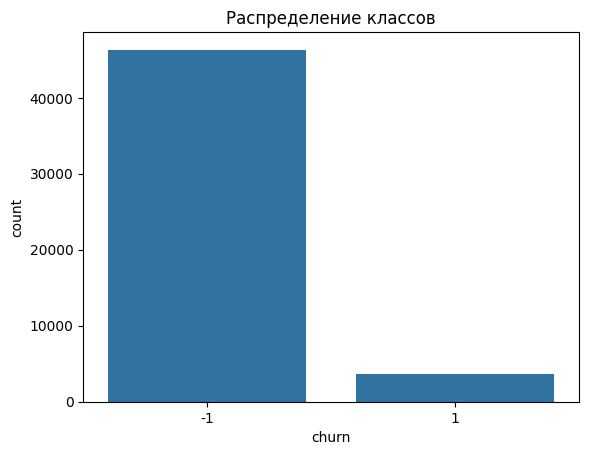

In [6]:
sns.countplot(x='churn', data=df)
plt.title("Распределение классов")
plt.show()

In [7]:
df['churn'].value_counts(normalize=True)

,proportion
churn,
-1,0.92656
1,0.07344


удаляем столбцы, в которых более 80 процентов пропусков

In [8]:
hit_threshold = 0.2
valid_cols = df.columns[df.isnull().mean() < (1 - hit_threshold)]
df = df[valid_cols]

Остальное заполняем 0

In [9]:
df.fillna(0, inplace=True)

In [10]:
categorical_cols = df.select_dtypes(include=["object", "category"]).columns
print(categorical_cols)

Index([], dtype='object')


Удаляем столбцы в которых всего 1 значение

In [11]:
nunique = df.nunique()
constant_cols = nunique[nunique <= 1].index
df.drop(columns=constant_cols, inplace=True)

## Отбор признаков

In [12]:
y = df['churn']
X = df.drop(columns=['churn'])

Убираем признаки с низкой дисперсией

In [13]:
selector = VarianceThreshold(threshold=0.0001)
X_var = selector.fit_transform(X)
selected_features_var = X.columns[selector.get_support()]
X = pd.DataFrame(X_var, columns=selected_features_var)

In [14]:
print(f"После VarianceThreshold: {X.shape[1]} признаков")

После VarianceThreshold: 3986 признаков


Mutual info анализ

In [15]:
X_sample, y_sample = X.sample(frac=0.1, random_state=42), y.sample(frac=0.1, random_state=42)

In [16]:
y_sample_bin = (y_sample == 1).astype(int)

In [17]:
mi_scores = mutual_info_classif(X_sample, y_sample_bin, discrete_features='auto', random_state=42)


In [18]:
mi_sorted = np.sort(mi_scores)[::-1]

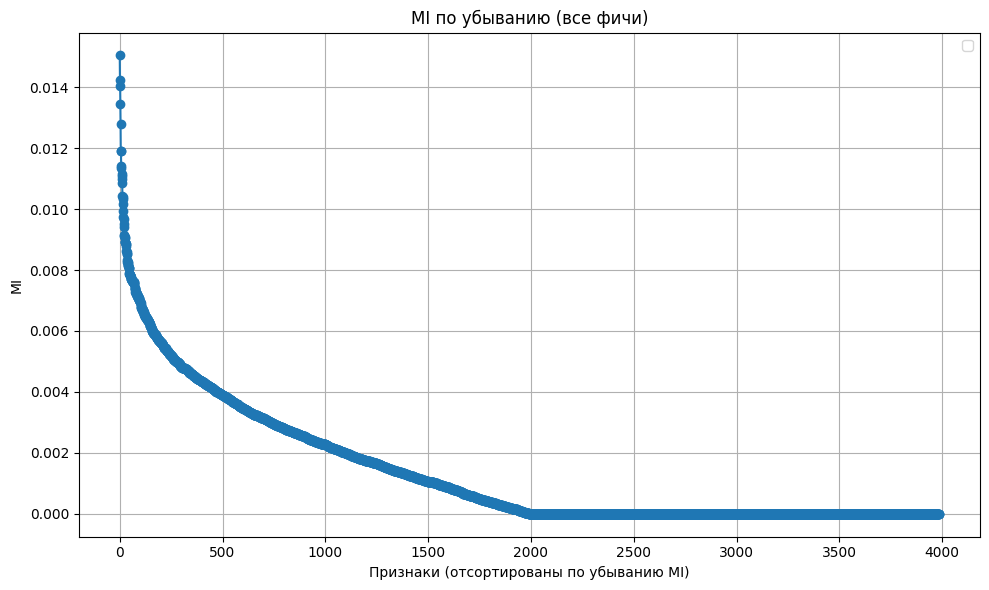

In [19]:
plt.figure(figsize=(10, 6))
plt.plot(mi_sorted, marker='o')
plt.title('MI по убыванию (все фичи)')
plt.xlabel('Признаки (отсортированы по убыванию MI)')
plt.ylabel('MI')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

Локоть на 2к

In [20]:
n = 2000

mi_df = pd.DataFrame({'Feature': X_sample.columns, 'MI_Score': mi_scores})
mi_df.sort_values('MI_Score', ascending=False, inplace=True)

top_n_features = mi_df.head(n)['Feature'].values

X_top_n = X_sample[top_n_features]

Смотрим попарную кореляцию

In [21]:
corr_matrix = X_top_n.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

corr_threshold = 0.95
to_drop = [col for col in upper.columns if any(upper[col] > corr_threshold)]

X_final = X_top_n.drop(columns=to_drop)

In [22]:
print(f"Исходно выбранных признаков по MI: {len(top_n_features)}")
print(f"Удалено из-за корреляции: {len(to_drop)}")
print(f"Осталось признаков: {X_final.shape[1]}")
print("Финальный список признаков:")
print(X_final.columns.tolist())

Исходно выбранных признаков по MI: 2000
Удалено из-за корреляции: 115
Осталось признаков: 1885
Финальный список признаков:
['Var1950', 'Var2852', 'Var1789', 'Var3925', 'Var721', 'Var4028', 'Var4023', 'Var2210', 'Var4031', 'Var1131', 'Var3682', 'Var3261', 'Var268', 'Var3592', 'Var2190', 'Var2104', 'Var2366', 'Var1996', 'Var3139', 'Var2531', 'Var1936', 'Var1075', 'Var798', 'Var1146', 'Var650', 'Var2466', 'Var3759', 'Var4154', 'Var417', 'Var1201', 'Var39', 'Var4136', 'Var3013', 'Var1224', 'Var3150', 'Var610', 'Var1365', 'Var796', 'Var3568', 'Var2741', 'Var4302', 'Var4209', 'Var2692', 'Var2516', 'Var386', 'Var2608', 'Var3532', 'Var1161', 'Var2051', 'Var355', 'Var1665', 'Var3035', 'Var886', 'Var531', 'Var985', 'Var1026', 'Var2451', 'Var2542', 'Var374', 'Var464', 'Var2242', 'Var3692', 'Var4126', 'Var2529', 'Var1487', 'Var452', 'Var2199', 'Var829', 'Var2870', 'Var2127', 'Var2769', 'Var4047', 'Var3502', 'Var3493', 'Var3893', 'Var4516', 'Var1018', 'Var2525', 'Var2500', 'Var2665', 'Var1446', 'Va

Создаем новый датасет с отобранными фичами

In [23]:
X_filtered = X[X_final.columns].copy()

In [24]:
print(f"Размер исходного датасета: {X.shape}")
print(f"Размер после отбора признаков: {X_filtered.shape}")

Размер исходного датасета: (50000, 3986)
Размер после отбора признаков: (50000, 1885)


## Заменяем категориальыне признаки с помощью OHE

In [25]:
cat_cols = [col for col in X_filtered.columns if X_filtered[col].nunique() <= 5]
print(f"Категориальных признаков для OHE: {len(cat_cols)}")


X_filtered_ohe = pd.get_dummies(X_filtered, columns=cat_cols, sparse=True, drop_first=True)

Категориальных признаков для OHE: 967


In [26]:
X_filtered_ohe.shape

(50000, 2165)

Отберем признаки с помощью XGB

In [27]:
y_corrected = y.copy()
y_corrected = y_corrected.replace(-1, 0).astype(int)


model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
model.fit(X_filtered_ohe, y_corrected)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, ...)

In [28]:
importance_dict = model.get_booster().get_score(importance_type='weight')

In [29]:
importance_df = pd.DataFrame({
    'feature': X.columns,
    'importance': [importance_dict.get(f, 0) for f in X.columns]
})

In [30]:
significant_features = importance_df[importance_df['importance'] > 0]['feature'].tolist()
X_significant = X_filtered_ohe[significant_features]

In [31]:
print(f"Оставлено признаков: {len(significant_features)} из {X.shape[1]}")


Оставлено признаков: 430 из 3986


## Обработка данных перед моделированием

стандартизация (так как лог регрессия)

In [32]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_significant)

In [33]:
X_temp, X_test, y_temp, y_test = train_test_split(X_scaled, y_corrected, test_size=0.2, random_state=42, stratify=None)


Поскольку у нас дисбаланс классов, делаем количество строк каждого класса в трейне одинаковым

In [34]:
idx_pos = np.where(y_temp == 1)[0]
idx_neg = np.where(y_temp == 0)[0]

min_len = min(len(idx_pos), len(idx_neg))


In [35]:
np.random.seed(42)
selected_pos = np.random.choice(idx_pos, min_len, replace=False)
selected_neg = np.random.choice(idx_neg, min_len, replace=False)

In [36]:
balanced_idx = np.concatenate([selected_pos, selected_neg])

In [37]:
X_train = X_temp[balanced_idx]
y_train = y_temp.iloc[balanced_idx]

Проверим на работоспособность

In [38]:
model = LogisticRegression(random_state=42, max_iter=1000)
model.fit(X_train, y_train)

LogisticRegression(max_iter=1000, random_state=42)

In [39]:
y_pred = model.predict(X_test)

In [40]:
f1 = f1_score(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

In [41]:
print("Метрики на тесте:")
print(f"F1-score: {f1:.4f}")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")

Метрики на тесте:
F1-score: 0.1760
Accuracy: 0.5796
Precision: 0.1025
Recall: 0.6210


In [42]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.95      0.58      0.72      9277
           1       0.10      0.62      0.18       723

    accuracy                           0.58     10000
   macro avg       0.53      0.60      0.45     10000
weighted avg       0.89      0.58      0.68     10000

